In [1]:
#imports
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
tf.disable_v2_behavior()
import matplotlib.pyplot as plt

2023-03-11 13:08:54.580966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 13:08:55.227230: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-11 13:08:55.443071: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-11 13:08:55.443101: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Task 0. Convolutional Forward Prop
"""
Write a function that performs forward propagation over a convolutional layer
of a neural network.
"""
def conv_forward(A_prev, W, b, activation, padding="same", stride=(1, 1)):
    """
    A_prev: numpy.ndarray of shape (m, h_prev, w_prev, c_prev) containing the
    output of the previous layer
        m: number of examples
        h_prev: height of the previous layer
        w_prev: width of the previous layer
        c_prev: number of channels in the previous layer
    W: numpy.ndarray of shape (kh, kw, c_prev, c_new) containing the kernels
    for the convolution
        kh: filter height
        kw: filter width
        c_prev: number of channels in the previous layer
        c_new: number of channels in the output
    b: numpy.ndarray of shape (1, 1, 1, c_new) containing the biases applied
    to the convolution
    activation: an activation function applied to the convolution
    padding: string that is either 'same' or 'valid' indicating the type of
    padding used
    stride: tuple of shape (sh, sw) containing the strides for the convolution
        sh: stride for the height
        sw: stride for the width
    Returns the output of the convolution layer
    """

    m = A_prev.shape[0]
    h_prev = A_prev.shape[1]
    w_prev = A_prev.shape[2]
    c_prev = A_prev.shape[3]

    kh = W.shape[0]
    kw = W.shape[1]
    kc_prev = W.shape[2]
    kc_new = W.shape[3]

    sh = stride[0]
    sw = stride[1]

    if padding == 'same':
        pad_top_bottom = (((h_prev - 1) * sh) + kh - h_prev) // 2
        pad_left_right = (((w_prev - 1) * sw) + kw - w_prev) // 2

    if padding == 'valid':
        pad_top_bottom = 0
        pad_left_right = 0

    A_prev = np.pad(A_prev, ((0, 0), (pad_top_bottom, pad_top_bottom),
                                 (pad_left_right, pad_left_right), (0, 0)))

    h_prev = (h_prev + 2 * pad_top_bottom - kh) // sh + 1
    w_prev = (w_prev + 2 * pad_left_right - kw) // sw + 1

    conv_image = np.zeros((m, h_prev, w_prev, kc_new))

    for x in range (h_prev):
        for y in range (w_prev):
            for z in range (kc_new):
                i = x * sh
                j = y * sw
                hadamard_prod = np.multiply(A_prev[:, i:i + kh, j:j + kw, :],
                                            W[:, :, :, z])
                conv_image[:, x, y, z] = np.sum(hadamard_prod, axis=(1, 2, 3))

    return activation(conv_image + b)

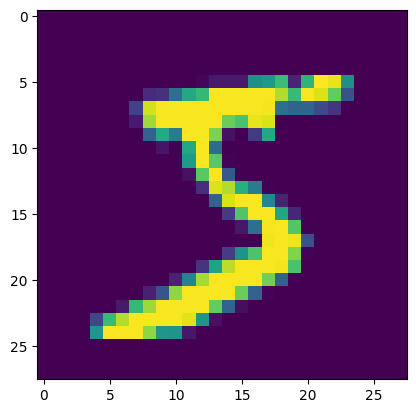

(50000, 26, 26, 2)


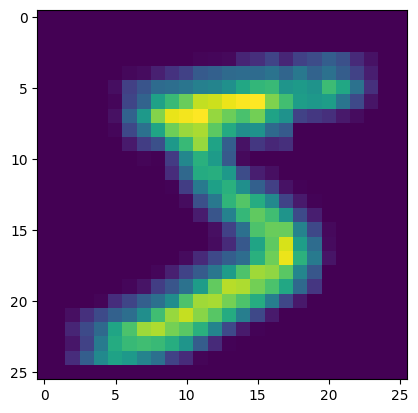

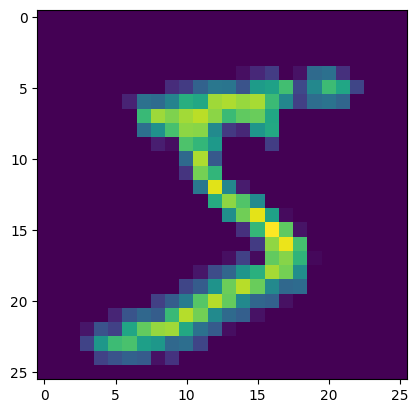

In [3]:
# 0-main
np.random.seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
m, h, w = X_train.shape
X_train_c = X_train.reshape((-1, h, w, 1))

W = np.random.randn(3, 3, 1, 2)
b = np.random.randn(1, 1, 1, 2)

def relu(Z):
    return np.maximum(Z, 0)

plt.imshow(X_train[0])
plt.show()
A = conv_forward(X_train_c, W, b, relu, padding='valid')
print(A.shape)
plt.imshow(A[0, :, :, 0])
plt.show()
plt.imshow(A[0, :, :, 1])
plt.show()

In [4]:
# Task 1. Pooling Forward Prop
"""
Write a function that performs forward propagation over a pooling layer of a
neural network
"""
def pool_forward(A_prev, kernel_shape, stride=(1, 1), mode='max'):
    """
    A_prev: numpy.ndarray of shape (m, h_prev, w_prev, c_prev) containing the
    output of the previous layer
        m: number of examples
        h_prev: height of the previous layer
        w_prev: width of the previous layer
        c_prev: number of channels in the previous layer
    kernel_shape: numpy.ndarray of shape (kh, kw) containing the kernels
    for the convolution
        kh: filter height
        kw: filter width
    stride: tuple of shape (sh, sw) containing the strides for the convolution
        sh: stride for the height
        sw: stride for the width
    mode: string containing either 'max' or 'avg', indicating whether to
    perform maximum or average pooling
    Returns the output of the pooling layer
    """
    m = A_prev.shape[0]
    h = A_prev.shape[1]
    w = A_prev.shape[2]
    c = A_prev.shape[3]

    kh = kernel_shape[0]
    kw = kernel_shape[1]

    sh = stride[0]
    sw = stride[1]

    h = (h - kh) // sh + 1
    w = (w - kw) // sw + 1

    output_image = np.zeros((m, h, w, c))

    for x in range(h):
        for y in range(w):
            i = x * sh
            j = y * sw
            if mode == 'max':
                output_image[:, x, y, :] = np.max(A_prev[:,
                                                         i:i + kh,
                                                         j:j + kw,
                                                         :], axis=(1, 2))
            if mode == 'avg':
                output_image[:, x, y, :] = np.mean(A_prev[:,
                                                          i:i + kh,
                                                          j:j + kw,
                                                          :], axis=(1, 2))
    return output_image

(50000, 28, 28, 2)


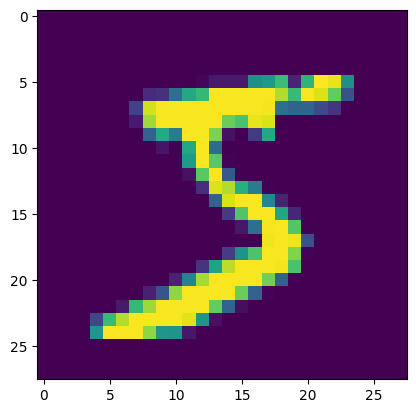

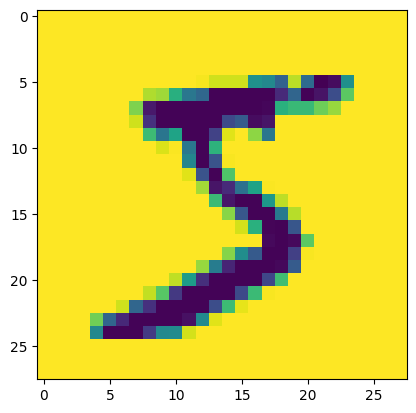

(50000, 14, 14, 2)


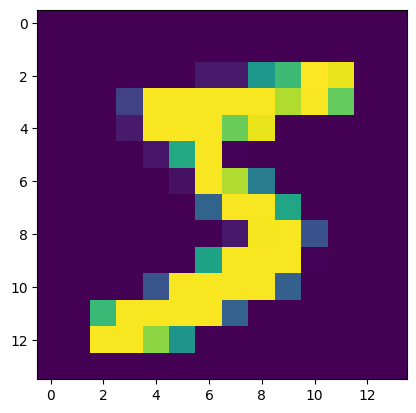

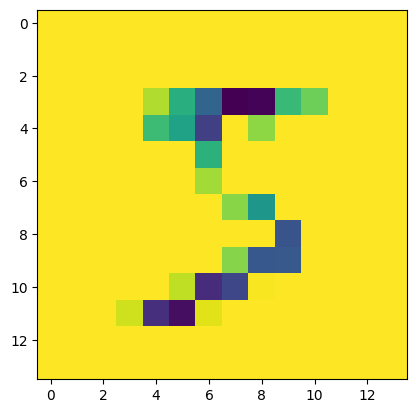

In [5]:
# 1-main
np.random.seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
m, h, w = X_train.shape
X_train_a = X_train.reshape((-1, h, w, 1))
X_train_b = 1 - X_train_a
X_train_c = np.concatenate((X_train_a, X_train_b), axis=3)

print(X_train_c.shape)
plt.imshow(X_train_c[0, :, :, 0])
plt.show()
plt.imshow(X_train_c[0, :, :, 1])
plt.show()
A = pool_forward(X_train_c, (2, 2), stride=(2, 2))
print(A.shape)
plt.imshow(A[0, :, :, 0])
plt.show()
plt.imshow(A[0, :, :, 1])
plt.show()

In [6]:
# Task 2. Convolutional Back Prop
"""
Write a function that performs back propagation over a convolutional layer of
a neural network
"""
def conv_backward(dZ, A_prev, W, b, padding="same", stride=(1, 1)):
    """
    dZ: numpy.ndarray of shape (m, h_new, w_new, c_new) containing the partial
    derivatives with respect to the unactivated output of the convolutional
    layer
        m: number of examples
        h_new: height of the output
        w_new: width of the output
        c_new: number of channels in the output
    A_prev: numpy.ndarray of shape (m, h_prev, w_prev, c_prev) containing the
    output of the previous layer
        m: number of examples
        h_prev: height of the previous layer
        w_prev: width of the previous layer
        c_prev: number of channels in the previous layer
    W: numpy.ndarray of shape (kh, kw, c_prev, c_new) containing the kernels
    for the convolution
        kh: filter height
        kw: filter width
        c_prev: number of channels in the previous layer
        c_new: number of channels in the output
    b: numpy.ndarray of shape (1, 1, 1, c_new) containing the biases applied
    to the convolution
    stride: tuple of shape (sh, sw) containing the strides for the convolution
        sh: stride for the height
        sw: stride for the width
    Returns the partial derivatives with respect to the previous layer
    (dA_prev), the kernels (dW) and the biases(db), respectively
    """
    m = dZ.shape[0]
    h_new = dZ.shape[1]
    w_new = dZ.shape[2]
    c_new = dZ.shape[3]

    h_prev = A_prev.shape[1]
    w_prev = A_prev.shape[2]
    c_prev = A_prev.shape[3]

    kh = W.shape[0]
    kw = W.shape[1]

    sh = stride[0]
    sw = stride[1]

    dA_prev = np.zeros_like(A_prev)
    dW = np.zeros_like(W)
    db = np.sum(dZ, axis=(0, 1, 2), keepdims=True)

    if padding == 'same':
        pad_top_bottom = (((h_prev - 1) * sh) + kh - h_prev) // 2 + 1
        pad_left_right = (((w_prev - 1) * sw) + kw - w_prev) // 2 + 1

    if padding == 'valid':
        pad_top_bottom = 0
        pad_left_right = 0

    A_prev = np.pad(A_prev, ((0, 0), (pad_top_bottom, pad_top_bottom),
                    (pad_left_right, pad_left_right), (0, 0)))

    dA_prev = np.pad(dA_prev, ((0, 0), (pad_top_bottom, pad_top_bottom),
                (pad_left_right, pad_left_right), (0, 0)))

    for image in range(m):
        for x in range (h_new):
            for y in range (w_new):
                for z in range (c_new):
                    i = x * sh
                    j = y * sw
                    dW[:, :, :, z] += np.multiply(A_prev[image, i:i + kh, j:j + kw, :], dZ[image, x, y, z])
                    dA_prev[image, i:i + kh, j:j + kw, :] += np.multiply(W[:, :, :, z], dZ[image, x, y, z])

    if padding == 'same':
        dA_prev = dA_prev[:, pad_top_bottom:-pad_top_bottom,
                          pad_left_right:-pad_left_right, :]

    return dA_prev, dW, db

In [7]:
# 2-main
np.random.seed(4)
m = np.random.randint(100, 200)
h, w = np.random.randint(20, 50, 2).tolist()
cin = np.random.randint(2, 5)
cout = np.random.randint(5, 10)
fh, fw = (np.random.randint(2, 5, 2)).tolist()
sh, sw = (np.random.randint(2, 4, 2)).tolist()

X = np.random.uniform(0, 1, (m, h, w, cin))
W = np.random.uniform(0, 1, (fh, fw, cin, cout))
b = np.random.uniform(0, 1, (1, 1, 1, cout))
dZ = np.random.uniform(0, 1, (m, (h - fh) // sh + 1, (w - fw) // sw + 1, cout))
dA, dW, db = conv_backward(dZ, X, W, b, padding="valid", stride=(sh, sw))
np.set_printoptions(threshold=np.inf)
# print(dA)
# print(dA.shape)
print(dW)
print(dW.shape)
print(db)
print(db.shape)

[[[[5662.39676986 5638.77968754 5631.94798171 5673.78131559
    5623.86161536]
   [5654.6340638  5616.39847615 5634.16068462 5642.25927946
    5608.52457114]
   [5635.17818097 5589.87139987 5624.12209594 5631.63168704
    5591.17158352]]

  [[5664.91311194 5619.57395814 5684.46783522 5706.61878162
    5636.58787342]
   [5592.01138195 5555.63616468 5570.24165208 5605.46755009
    5556.16677175]
   [5657.00800948 5598.6163136  5636.11226755 5660.87895399
    5597.31357776]]

  [[5665.47233809 5608.57956045 5633.13627243 5655.25468074
    5626.74848556]
   [5639.7368176  5626.20997466 5613.74494714 5620.55060696
    5588.03992724]
   [5656.89014452 5582.45297384 5589.69406662 5648.970037
    5592.10500034]]

  [[5690.19502477 5627.13913719 5660.91193705 5688.05791281
    5614.0212746 ]
   [5603.61864072 5586.30518704 5595.57779288 5598.77337851
    5541.24190795]
   [5647.44800195 5632.48263382 5636.11970622 5673.29784943
    5600.00018716]]]


 [[[5623.80082957 5575.29126141 5612.9180871

In [51]:
# Task 3. Pooling Back Prop
"""
Write a function that performs back propagation over a pooling layer of a 
neural network
"""
np.set_printoptions(suppress=True)
def pool_backward(dA, A_prev, kernel_shape, stride=(1, 1), mode='max'):
    """
    dA: numpy.ndarray of shape (m, h_new, w_new, c_new) containing the partial
    derivatives with respect to the output of the pooling layer
        m: number of examples
        h_new: height of the output
        w_new: width of the output
        c: number of channels
    A_prev: numpy.ndarray of shape (m, h_prev, w_prev, c) containing the output
    of the previous layer
        m: number of examples
        h_prev: height of the previous layer
        w_prev: width of the previous layer
        c: number of channels
    kernel_shape: tuple of (kh, kw) containing the size of the kernel for
    pooling
        kh: kernel height
        kw: kernel width
    stride: tuple of (sh, sw) containing the strides for the pooling
        sh: stride for the height
        sw: stride for the width
    mode: string containing either 'max' or 'avg' indicating whether to
    perform maximum or average pooling, respectively
    Returns the partial derivatives with respect to the previous layer
    (dA_prev)
    """
    m = dA.shape[0]
    h_new = dA.shape[1]
    w_new = dA.shape[2]
    c_new = dA.shape[3]

    h_prev = A_prev.shape[1]
    w_prev = A_prev.shape[2]
    c = A_prev.shape[3]

    kh = kernel_shape[0]
    kw = kernel_shape[1]

    sh = stride[0]
    sw = stride[1]

    dA_prev = np.zeros_like(A_prev)

    for image in range(m):
        for x in range(h_new):
            for y in range(w_new):
                for z in range(c_new):
                    i = sh * x
                    j = sw * y
                    if mode == 'max':
                        a_prev_slice = A_prev[image, i:i + kh, j:j + kw, z]
                        mask = (a_prev_slice == np.max(a_prev_slice))
                        dA_prev[image, i:i + kh, j:j + kw, z] += (mask * dA[image, x, y, z])
                    if mode == 'avg':
                        avgerage_dA = dA[image, x, y, z] / kh / kw
                        dA_prev[image, i:i + kh, j:j + kw, z] += np.ones(
                            (kh, kw)) * avgerage_dA
    return dA_prev


In [52]:
# 3-main
np.random.seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
_, h, w = X_train.shape
X_train_a = X_train[:10].reshape((-1, h, w, 1))
X_train_b = 1 - X_train_a
X_train_c = np.concatenate((X_train_a, X_train_b), axis=3)

dA = np.random.randn(10, h // 3, w // 3, 2)
print(pool_backward(dA, X_train_c, (3, 3), stride=(3, 3)))

[[[[ 1.7640524   0.4001572 ]
   [ 1.7640524   0.4001572 ]
   [ 1.7640524   0.4001572 ]
   [ 0.978738    2.2408931 ]
   [ 0.978738    2.2408931 ]
   [ 0.978738    2.2408931 ]
   [ 1.867558   -0.9772779 ]
   [ 1.867558   -0.9772779 ]
   [ 1.867558   -0.9772779 ]
   [ 0.95008844 -0.1513572 ]
   [ 0.95008844 -0.1513572 ]
   [ 0.95008844 -0.1513572 ]
   [-0.10321885  0.41059852]
   [-0.10321885  0.41059852]
   [-0.10321885  0.41059852]
   [ 0.14404356  1.4542735 ]
   [ 0.14404356  1.4542735 ]
   [ 0.14404356  1.4542735 ]
   [ 0.7610377   0.12167501]
   [ 0.7610377   0.12167501]
   [ 0.7610377   0.12167501]
   [ 0.44386324  0.33367434]
   [ 0.44386324  0.33367434]
   [ 0.44386324  0.33367434]
   [ 1.4940791  -0.20515826]
   [ 1.4940791  -0.20515826]
   [ 1.4940791  -0.20515826]
   [ 0.          0.        ]]

  [[ 1.7640524   0.4001572 ]
   [ 1.7640524   0.4001572 ]
   [ 1.7640524   0.4001572 ]
   [ 0.978738    2.2408931 ]
   [ 0.978738    2.2408931 ]
   [ 0.978738    2.2408931 ]
   [ 1.86755